## Contour-based approach

Processing t_set images:
t_frame1.jpg - Labeled Angles: {'lower_left': 0.8316918287487847, 'lower_right': 0.8174300994670607, 'upper': 1.4924707253739489}  (Runtime: 0.014807 s)


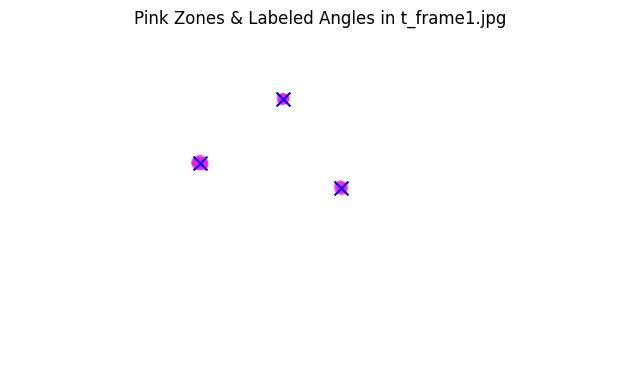

t_frame2.jpg - Labeled Angles: {'lower_left': 1.664660172018717, 'lower_right': 0.7768444319411523, 'upper': 0.7000880496299232}  (Runtime: 0.014054 s)


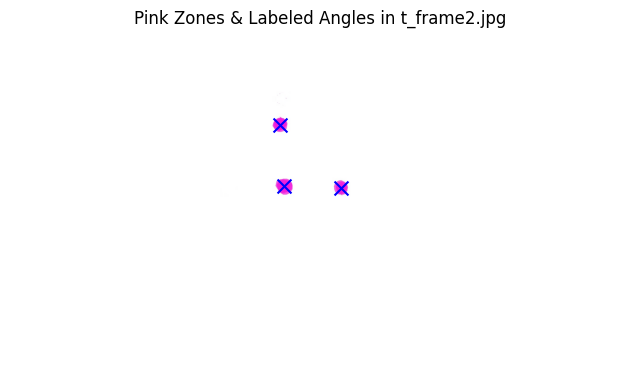

t_frame3.jpg - Labeled Angles: {'lower_left': 0.4108095619500193, 'lower_right': 0.9120130122472232, 'upper': 1.818770079392551}  (Runtime: 0.014131 s)


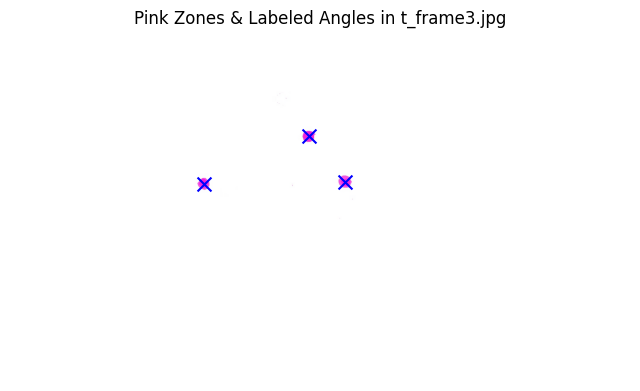

t_frame4.jpg - Labeled Angles: {'lower_left': 0.30807570973974974, 'lower_right': 2.543603756186502, 'upper': 0.28991318766354013}  (Runtime: 0.017663 s)


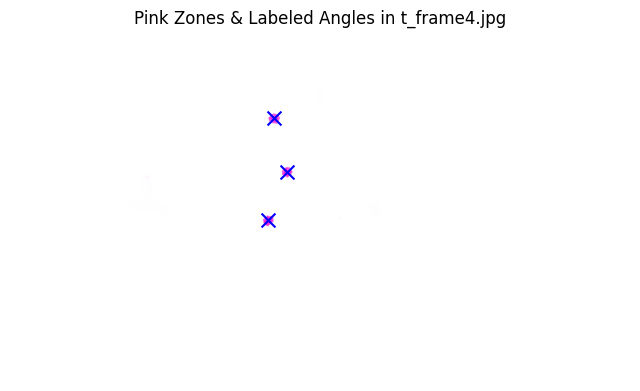

Processing s_set images:
s_frame1.jpg - Labeled Angles: {'lower_left': 1.0442947418355926, 'lower_right': 0.6016825090215394, 'upper': 1.4956154027326627}  (Runtime: 0.015271 s)


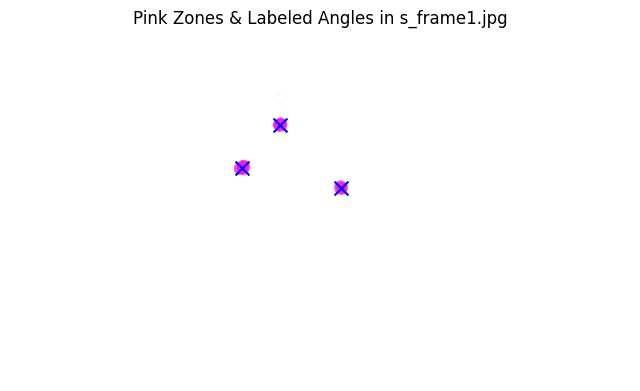

s_frame2.jpg - Labeled Angles: {'lower_left': 1.8191238704996708, 'lower_right': 0.6663499042593357, 'upper': 0.6561188788307867}  (Runtime: 0.014081 s)


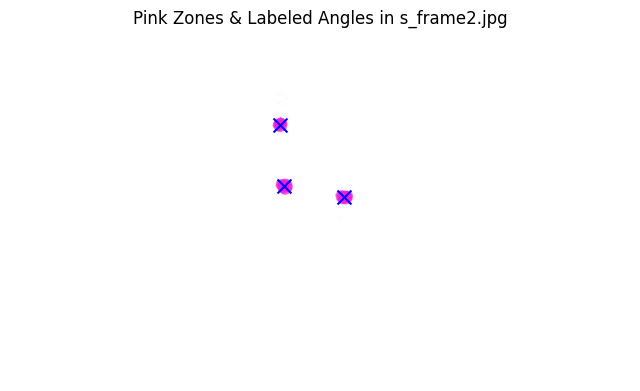

s_frame3.jpg - Labeled Angles: {'lower_left': 0.586607800073492, 'lower_right': 1.0834297537381796, 'upper': 1.4715550997781217}  (Runtime: 0.016360 s)


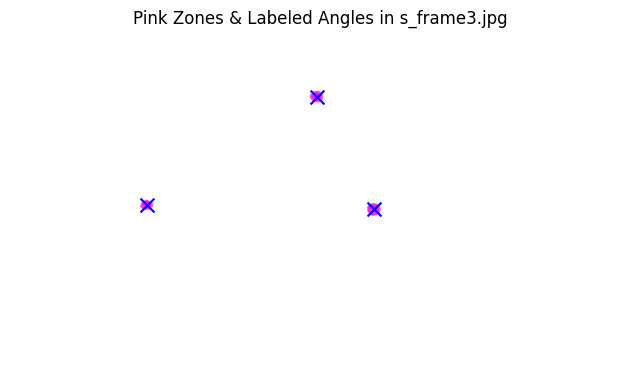

s_frame4.jpg - Labeled Angles: {'lower_left': 0.3570023086255274, 'lower_right': 2.5399206705850057, 'upper': 0.24466967437925913}  (Runtime: 0.015729 s)


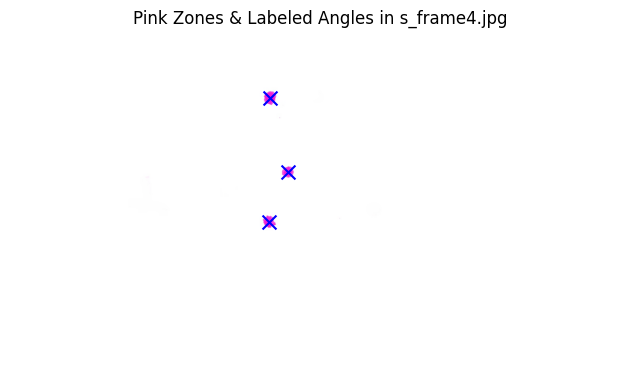


Angle Sequences:
t_set lower_left: [0.8316918287487847, 1.664660172018717, 0.4108095619500193, 0.30807570973974974]
s_set lower_left: [1.0442947418355926, 1.8191238704996708, 0.586607800073492, 0.3570023086255274]
t_set lower_right: [0.8174300994670607, 0.7768444319411523, 0.9120130122472232, 2.543603756186502]
s_set lower_right: [0.6016825090215394, 0.6663499042593357, 1.0834297537381796, 2.5399206705850057]
t_set upper: [1.4924707253739489, 0.7000880496299232, 1.818770079392551, 0.28991318766354013]
s_set upper: [1.4956154027326627, 0.6561188788307867, 1.4715550997781217, 0.24466967437925913]

DTW Distances:
Lower Left DTW: 0.591791
Lower Right DTW: 0.501342
Upper DTW: 0.439572
Total DTW Score (sum of all three): 1.532706


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import itertools

def cordic_atan(y, x, iterations=20):
    """
    Compute the arctan of y/x using the CORDIC algorithm.
    Returns the angle in radians.
    """
    angle = 0.0
    arctan_table = [math.atan(2**(-i)) for i in range(iterations)]

    # For vectoring mode, if x is negative, flip the vector and add pi.
    if x < 0:
        x, y = -x, -y
        angle = math.pi

    for i in range(iterations):
        d = 1 if y > 0 else -1
        x_new = x + d * y * (2 ** -i)
        y_new = y - d * x * (2 ** -i)
        angle += d * arctan_table[i]
        x, y = x_new, y_new
    return angle

def compute_triangle_angles(pts, iterations=20):
    """
    Given three points (shape (3,2)), compute the internal angles
    of the triangle using the CORDIC-based arctan.
    Returns a list of three angles (in radians), in the same order as pts.
    """
    angles = []
    for i in range(3):
        A = pts[i]
        B = pts[(i + 1) % 3]
        C = pts[(i + 2) % 3]
        # Vectors from A to B and from A to C
        v1 = (B[0] - A[0], B[1] - A[1])
        v2 = (C[0] - A[0], C[1] - A[1])
        angle1 = cordic_atan(v1[1], v1[0], iterations)
        angle2 = cordic_atan(v2[1], v2[0], iterations)
        angle_diff = abs(angle1 - angle2)
        if angle_diff > math.pi:
            angle_diff = 2 * math.pi - angle_diff
        angles.append(angle_diff)
    return angles

def label_triangle_angles(cluster_centers, triangle_angles):
    """
    Given three vertices (cluster_centers, shape (3,2)) and their computed internal angles,
    assign each vertex a label based on its normalized position.
    Normalization is done using the bounding box of the vertices.
    Target positions in normalized coordinates are defined as:
       lower_left: (0, 1)
       lower_right: (1, 1)
       upper: (0.5, 0)
    This function returns a dictionary mapping:
      {'lower_left': angle, 'lower_right': angle, 'upper': angle}
    using the assignment that minimizes the total distance between vertices and these targets.
    """
    # Compute bounding box
    xs = cluster_centers[:,0]
    ys = cluster_centers[:,1]
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)

    # Normalize each vertex coordinate to [0,1]
    normalized = []
    for (x, y) in cluster_centers:
        x_norm = (x - x_min) / (x_max - x_min) if x_max != x_min else 0.0
        y_norm = (y - y_min) / (y_max - y_min) if y_max != y_min else 0.0
        normalized.append((x_norm, y_norm))

    # Define target positions for each label in normalized coordinates
    targets = {'lower_left': (0, 1),
               'lower_right': (1, 1),
               'upper': (0.5, 0)}
    labels = ['lower_left', 'lower_right', 'upper']

    # Try all assignments (permutations) of vertices to labels
    best_perm = None
    best_score = np.inf
    for perm in itertools.permutations(range(3)):
        score = 0
        for label_index, vertex_index in enumerate(perm):
            target = targets[labels[label_index]]
            x_norm, y_norm = normalized[vertex_index]
            score += math.sqrt((x_norm - target[0])**2 + (y_norm - target[1])**2)
        if score < best_score:
            best_score = score
            best_perm = perm

    # Map the best assignment to corresponding angles
    labeled_angles = { labels[0]: triangle_angles[best_perm[0]],
                       labels[1]: triangle_angles[best_perm[1]],
                       labels[2]: triangle_angles[best_perm[2]] }
    return labeled_angles

def process_image(image_path):
    """
    Processes an image to:
      - Detect pink zones via HSV masking.
      - Compute centroids of the 3 largest pink zones.
      - Compute triangle internal angles using a CORDIC-based arctan.
      - Label the angles as 'lower_left', 'lower_right', and 'upper' based on vertex positions.
      - Measure runtime.
    Returns the image, cluster_centers, the labeled angles (a dict), and runtime.
    """
    start_time = time.time()

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found: " + image_path)

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_pink = np.array([140, 50, 50])
    upper_pink = np.array([180, 255, 255])
    mask = cv2.inRange(image_hsv, lower_pink, upper_pink)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 50
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    if len(filtered_contours) < 3:
        raise ValueError("Less than 3 pink zones found in " + image_path)

    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:3]

    cluster_centers = []
    for cnt in filtered_contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = cnt[0][0]
        cluster_centers.append((cx, cy))
    cluster_centers = np.array(cluster_centers)

    triangle_angles = compute_triangle_angles(cluster_centers, iterations=20)
    labeled_angles = label_triangle_angles(cluster_centers, triangle_angles)

    end_time = time.time()
    runtime = end_time - start_time
    return image, cluster_centers, labeled_angles, runtime

# Optimized DTW function provided
def DTWDistance(s, t):
    n = len(s)
    m = len(t)
    prev_row = np.full(m+1, np.inf)
    current_row = np.full(m+1, np.inf)
    prev_row[0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            current_row[j] = cost + min(prev_row[j], current_row[j-1], prev_row[j-1])
        prev_row[:] = current_row
        current_row[:] = np.inf
    return prev_row[m]

# Define image file sets
t_set = ['t_frame1.jpg', 't_frame2.jpg', 't_frame3.jpg', 't_frame4.jpg']
s_set = ['s_frame1.jpg', 's_frame2.jpg', 's_frame3.jpg', 's_frame4.jpg']

# Dictionaries to store labeled angles for later DTW comparison
labeled_angles_t = {}
labeled_angles_s = {}

print("Processing t_set images:")
for image_path in t_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_t[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles}  (Runtime: {runtime:.6f} s)")

        # Visualization
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        plt.title(f"Pink Zones & Labeled Angles in {image_path}")
        plt.axis('off')
        plt.show()
    except ValueError as e:
        print(e)

print("Processing s_set images:")
for image_path in s_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_s[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles}  (Runtime: {runtime:.6f} s)")

        # Visualization
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        plt.title(f"Pink Zones & Labeled Angles in {image_path}")
        plt.axis('off')
        plt.show()
    except ValueError as e:
        print(e)

# Build angle sequences for each label across images in t_set and s_set.
# The order is assumed to be the order in t_set/s_set lists.
def build_angle_sequence(labeled_angles_dict, label, image_list):
    sequence = []
    for img in image_list:
        angles = labeled_angles_dict.get(img)
        if angles is not None:
            sequence.append(angles[label])
    return sequence

# For each label: lower_left, lower_right, and upper.
t_lower_left_seq = build_angle_sequence(labeled_angles_t, 'lower_left', t_set)
t_lower_right_seq = build_angle_sequence(labeled_angles_t, 'lower_right', t_set)
t_upper_seq = build_angle_sequence(labeled_angles_t, 'upper', t_set)

s_lower_left_seq = build_angle_sequence(labeled_angles_s, 'lower_left', s_set)
s_lower_right_seq = build_angle_sequence(labeled_angles_s, 'lower_right', s_set)
s_upper_seq = build_angle_sequence(labeled_angles_s, 'upper', s_set)

print("\nAngle Sequences:")
print("t_set lower_left:", t_lower_left_seq)
print("s_set lower_left:", s_lower_left_seq)
print("t_set lower_right:", t_lower_right_seq)
print("s_set lower_right:", s_lower_right_seq)
print("t_set upper:", t_upper_seq)
print("s_set upper:", s_upper_seq)

# Compute DTW distances for each angle sequence
dtw_lower_left = DTWDistance(t_lower_left_seq, s_lower_left_seq)
dtw_lower_right = DTWDistance(t_lower_right_seq, s_lower_right_seq)
dtw_upper = DTWDistance(t_upper_seq, s_upper_seq)

total_dtw = dtw_lower_left + dtw_lower_right + dtw_upper

print("\nDTW Distances:")
print(f"Lower Left DTW: {dtw_lower_left:.6f}")
print(f"Lower Right DTW: {dtw_lower_right:.6f}")
print(f"Upper DTW: {dtw_upper:.6f}")
print(f"Total DTW Score (sum of all three): {total_dtw:.6f}")


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

def cordic_atan(y, x, iterations=20):
    """
    Compute the arctan of y/x using the CORDIC algorithm.
    Returns the angle in radians.
    """
    angle = 0.0
    arctan_table = [math.atan(2**(-i)) for i in range(iterations)]

    # If x is negative, flip the vector and add pi.
    if x < 0:
        x, y = -x, -y
        angle = math.pi

    for i in range(iterations):
        d = 1 if y > 0 else -1
        x_new = x + d * y * (2 ** -i)
        y_new = y - d * x * (2 ** -i)
        angle += d * arctan_table[i]
        x, y = x_new, y_new
    return angle

def compute_triangle_angles(pts, iterations=20):
    """
    Given three points (shape (3,2)), compute the internal angles
    of the triangle using the CORDIC-based arctan.
    Returns a list of three angles (in radians) in the same order as pts.
    """
    angles = []
    for i in range(3):
        A = pts[i]
        B = pts[(i + 1) % 3]
        C = pts[(i + 2) % 3]
        # Vectors from A to B and from A to C
        v1 = (B[0] - A[0], B[1] - A[1])
        v2 = (C[0] - A[0], C[1] - A[1])
        angle1 = cordic_atan(v1[1], v1[0], iterations)
        angle2 = cordic_atan(v2[1], v2[0], iterations)
        angle_diff = abs(angle1 - angle2)
        if angle_diff > math.pi:
            angle_diff = 2 * math.pi - angle_diff
        angles.append(angle_diff)
    return angles

def label_triangle_angles_simplified(cluster_centers, triangle_angles):
    """
    Label the triangle vertices as:
      - 'upper': the vertex with the smallest y coordinate (upper in image coordinates).
      - 'lower_left': among the remaining vertices, the one with the smaller x coordinate.
      - 'lower_right': among the remaining vertices, the one with the larger x coordinate.
    Returns a dictionary mapping each label to its corresponding angle.
    """
    # cluster_centers: numpy array of shape (3,2) with columns (x, y)
    upper_idx = np.argmin(cluster_centers[:, 1])  # smallest y => upper (for image coordinates)
    other_indices = [i for i in range(3) if i != upper_idx]

    # Compare x coordinates of the two remaining vertices
    if cluster_centers[other_indices[0], 0] < cluster_centers[other_indices[1], 0]:
        lower_left_idx = other_indices[0]
        lower_right_idx = other_indices[1]
    else:
        lower_left_idx = other_indices[1]
        lower_right_idx = other_indices[0]

    labeled_angles = {
        'upper': triangle_angles[upper_idx],
        'lower_left': triangle_angles[lower_left_idx],
        'lower_right': triangle_angles[lower_right_idx]
    }
    return labeled_angles

def process_image(image_path):
    """
    Processes an image to:
      - Detect pink zones via HSV masking.
      - Compute centroids of the 3 largest pink zones.
      - Compute triangle internal angles using CORDIC-based arctan.
      - Label the angles as 'upper', 'lower_left', and 'lower_right' using the simplified criteria.
      - Measure runtime.
    Returns the image, cluster_centers, labeled_angles (a dict), and runtime.
    """
    start_time = time.time()

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found: " + image_path)

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_pink = np.array([140, 50, 50])
    upper_pink = np.array([180, 255, 255])
    mask = cv2.inRange(image_hsv, lower_pink, upper_pink)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 50
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    if len(filtered_contours) < 3:
        raise ValueError("Less than 3 pink zones found in " + image_path)

    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:3]

    cluster_centers = []
    for cnt in filtered_contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = cnt[0][0]
        cluster_centers.append((cx, cy))
    cluster_centers = np.array(cluster_centers)

    triangle_angles = compute_triangle_angles(cluster_centers, iterations=20)
    labeled_angles = label_triangle_angles_simplified(cluster_centers, triangle_angles)

    end_time = time.time()
    runtime = end_time - start_time
    return image, cluster_centers, labeled_angles, runtime

# Optimized DTW function provided
def DTWDistance(s, t):
    n = len(s)
    m = len(t)
    prev_row = np.full(m+1, np.inf)
    current_row = np.full(m+1, np.inf)
    prev_row[0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            current_row[j] = cost + min(prev_row[j], current_row[j-1], prev_row[j-1])
        prev_row[:] = current_row
        current_row[:] = np.inf
    return prev_row[m]

# Define image file sets
t_set = ['t_frame1.jpg', 't_frame2.jpg', 't_frame3.jpg', 't_frame4.jpg']
s_set = ['s_frame1.jpg', 's_frame2.jpg', 's_frame3.jpg', 's_frame4.jpg']

# Dictionaries to store labeled angles for DTW
labeled_angles_t = {}
labeled_angles_s = {}

# Start global timer for the entire pipeline
global_start_time = time.time()

print("Processing t_set images:")
for image_path in t_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_t[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Commented out image visualization
        # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # plt.figure(figsize=(8, 6))
        # plt.imshow(image_rgb)
        # plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        # plt.title(f"Pink Zones & Labeled Angles in {image_path}")
        # plt.axis('off')
        # plt.show()
    except ValueError as e:
        print(e)

print("Processing s_set images:")
for image_path in s_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_s[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Commented out image visualization
        # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # plt.figure(figsize=(8, 6))
        # plt.imshow(image_rgb)
        # plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        # plt.title(f"Pink Zones & Labeled Angles in {image_path}")
        # plt.axis('off')
        # plt.show()
    except ValueError as e:
        print(e)

# Build angle sequences for each label across images in t_set and s_set.
def build_angle_sequence(labeled_angles_dict, label, image_list):
    sequence = []
    for img in image_list:
        angles = labeled_angles_dict.get(img)
        if angles is not None:
            sequence.append(angles[label])
    return sequence

# For each label: lower_left, lower_right, and upper.
t_lower_left_seq = build_angle_sequence(labeled_angles_t, 'lower_left', t_set)
t_lower_right_seq = build_angle_sequence(labeled_angles_t, 'lower_right', t_set)
t_upper_seq = build_angle_sequence(labeled_angles_t, 'upper', t_set)

s_lower_left_seq = build_angle_sequence(labeled_angles_s, 'lower_left', s_set)
s_lower_right_seq = build_angle_sequence(labeled_angles_s, 'lower_right', s_set)
s_upper_seq = build_angle_sequence(labeled_angles_s, 'upper', s_set)

print("\nAngle Sequences:")
print("t_set lower_left:", t_lower_left_seq)
print("s_set lower_left:", s_lower_left_seq)
print("t_set lower_right:", t_lower_right_seq)
print("s_set lower_right:", s_lower_right_seq)
print("t_set upper:", t_upper_seq)
print("s_set upper:", s_upper_seq)

# Compute DTW distances for each angle sequence
dtw_lower_left = DTWDistance(t_lower_left_seq, s_lower_left_seq)
dtw_lower_right = DTWDistance(t_lower_right_seq, s_lower_right_seq)
dtw_upper = DTWDistance(t_upper_seq, s_upper_seq)

total_dtw = dtw_lower_left + dtw_lower_right + dtw_upper

print("\nDTW Distances:")
print(f"Lower Left DTW: {dtw_lower_left:.6f}")
print(f"Lower Right DTW: {dtw_lower_right:.6f}")
print(f"Upper DTW: {dtw_upper:.6f}")
print(f"Total DTW Score (sum of all three): {total_dtw:.6f}")

# End global timer and print total runtime
global_end_time = time.time()
print(f"\nTotal pipeline runtime: {global_end_time - global_start_time:.6f} seconds")


Processing t_set images:
t_frame1.jpg - Labeled Angles: {'upper': 1.4924707253739489, 'lower_left': 0.8316918287487847, 'lower_right': 0.8174300994670607} (Runtime: 0.013295 s)
t_frame2.jpg - Labeled Angles: {'upper': 0.7000880496299232, 'lower_left': 1.664660172018717, 'lower_right': 0.7768444319411523} (Runtime: 0.012698 s)
t_frame3.jpg - Labeled Angles: {'upper': 1.818770079392551, 'lower_left': 0.4108095619500193, 'lower_right': 0.9120130122472232} (Runtime: 0.013024 s)
t_frame4.jpg - Labeled Angles: {'upper': 0.28991318766354013, 'lower_left': 0.30807570973974974, 'lower_right': 2.543603756186502} (Runtime: 0.013325 s)
Processing s_set images:
s_frame1.jpg - Labeled Angles: {'upper': 1.4956154027326627, 'lower_left': 1.0442947418355926, 'lower_right': 0.6016825090215394} (Runtime: 0.012569 s)
s_frame2.jpg - Labeled Angles: {'upper': 0.6561188788307867, 'lower_left': 1.8191238704996708, 'lower_right': 0.6663499042593357} (Runtime: 0.012643 s)
s_frame3.jpg - Labeled Angles: {'upper'

## Non-maximum suppression

Processing t_set images:
t_frame1.jpg - Labeled Angles: {'upper': 1.5037848344280702, 'lower_left': 0.8378830427550152, 'lower_right': 0.7999247764067072} (Runtime: 0.028432 s)


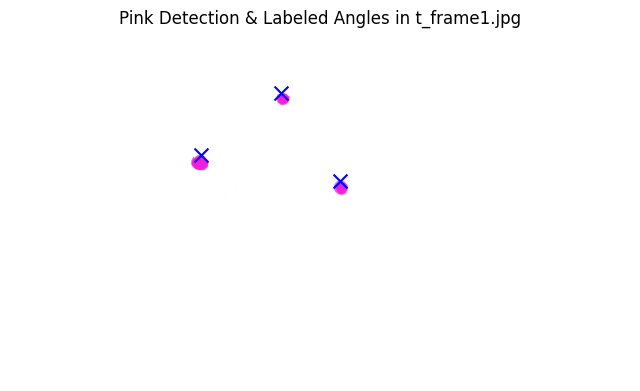

t_frame2.jpg - Labeled Angles: {'upper': 0.3618734037794329, 'lower_left': 2.649595443866429, 'lower_right': 0.13012380594393314} (Runtime: 0.032643 s)


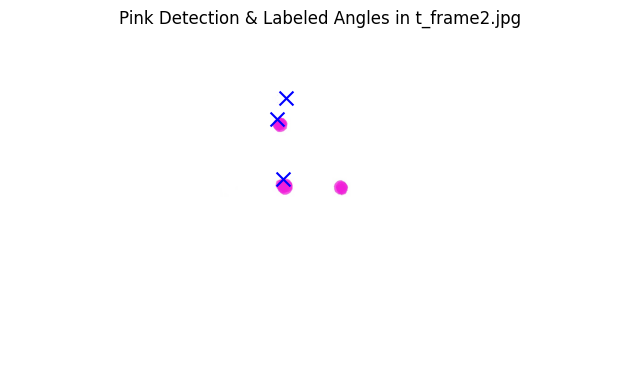

t_frame3.jpg - Labeled Angles: {'upper': 0.06570308109281908, 'lower_left': 3.031310061312898, 'lower_right': 0.04457951118407699} (Runtime: 0.026748 s)


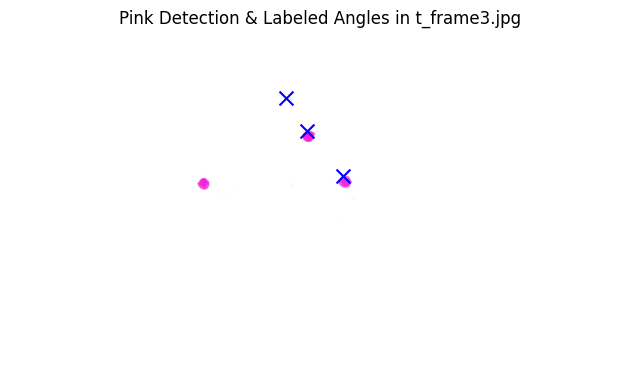

t_frame4.jpg - Labeled Angles: {'upper': 0.3048337908198273, 'lower_left': 0.3238246487235683, 'lower_right': 2.512934214046399} (Runtime: 0.025500 s)


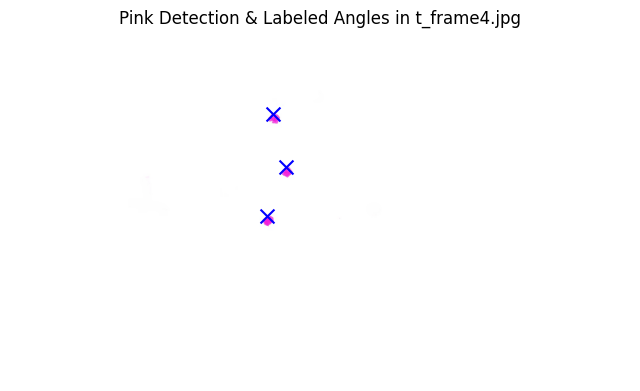

Processing s_set images:
s_frame1.jpg - Labeled Angles: {'upper': 0.19949180043508474, 'lower_left': 0.08307107977578077, 'lower_right': 2.859029773378928} (Runtime: 0.031426 s)


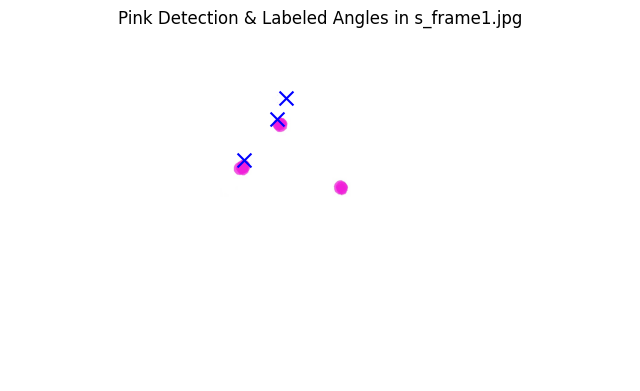

s_frame2.jpg - Labeled Angles: {'upper': 0.3618734037794329, 'lower_left': 2.649595443866429, 'lower_right': 0.13012380594393314} (Runtime: 0.032263 s)


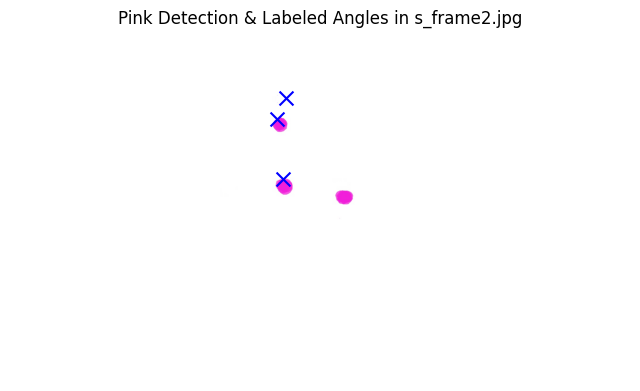

s_frame3.jpg - Labeled Angles: {'upper': 1.4535099899969217, 'lower_left': 0.583447364682328, 'lower_right': 1.1046352989105412} (Runtime: 0.037113 s)


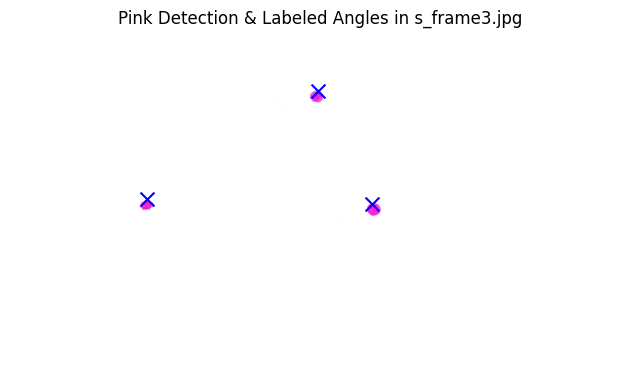

s_frame4.jpg - Labeled Angles: {'upper': 0.1287270574590531, 'lower_left': 2.940553468900317, 'lower_right': 0.07231212723042546} (Runtime: 0.157614 s)


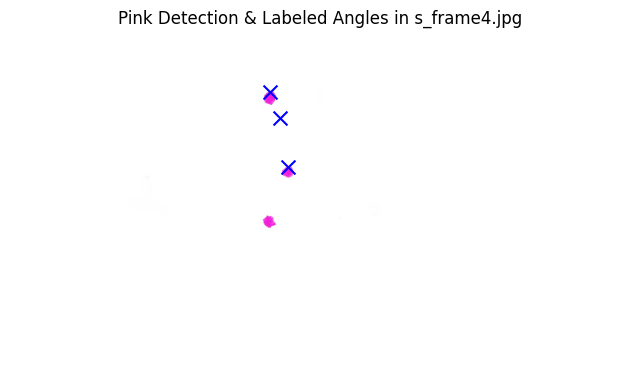


Angle Sequences:
t_set lower_left: [0.8378830427550152, 2.649595443866429, 3.031310061312898, 0.3238246487235683]
s_set lower_left: [0.08307107977578077, 2.649595443866429, 0.583447364682328, 2.940553468900317]
t_set lower_right: [0.7999247764067072, 0.13012380594393314, 0.04457951118407699, 2.512934214046399]
s_set lower_right: [2.859029773378928, 0.13012380594393314, 1.1046352989105412, 0.07231212723042546]
t_set upper: [1.5037848344280702, 0.3618734037794329, 0.06570308109281908, 0.3048337908198273]
s_set upper: [0.19949180043508474, 0.3618734037794329, 1.4535099899969217, 0.1287270574590531]

DTW Distances:
Lower Left DTW: 4.012878
Lower Right DTW: 5.501971
Upper DTW: 2.635060
Total DTW Score (sum of all three): 12.149910

Total pipeline runtime: 2.234659 seconds


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

def cordic_atan(y, x, iterations=20):
    """
    Compute the arctan of y/x using the CORDIC algorithm.
    Returns the angle in radians.
    """
    angle = 0.0
    arctan_table = [math.atan(2**(-i)) for i in range(iterations)]

    # If x is negative, flip the vector and add pi.
    if x < 0:
        x, y = -x, -y
        angle = math.pi

    for i in range(iterations):
        d = 1 if y > 0 else -1
        x_new = x + d * y * (2 ** -i)
        y_new = y - d * x * (2 ** -i)
        angle += d * arctan_table[i]
        x, y = x_new, y_new
    return angle

def compute_triangle_angles(pts, iterations=20):
    """
    Given three points (shape (3,2)), compute the internal angles
    of the triangle using the CORDIC-based arctan.
    Returns a list of three angles (in radians) in the same order as pts.
    """
    angles = []
    for i in range(3):
        A = pts[i]
        B = pts[(i + 1) % 3]
        C = pts[(i + 2) % 3]
        # Vectors from A to B and from A to C
        v1 = (B[0] - A[0], B[1] - A[1])
        v2 = (C[0] - A[0], C[1] - A[1])
        angle1 = cordic_atan(v1[1], v1[0], iterations)
        angle2 = cordic_atan(v2[1], v2[0], iterations)
        angle_diff = abs(angle1 - angle2)
        if angle_diff > math.pi:
            angle_diff = 2 * math.pi - angle_diff
        angles.append(angle_diff)
    return angles

def label_triangle_angles_simplified(cluster_centers, triangle_angles):
    """
    Label the triangle vertices as:
      - 'upper': the vertex with the smallest y coordinate (upper in image coordinates).
      - 'lower_left': among the remaining vertices, the one with the smaller x coordinate.
      - 'lower_right': among the remaining vertices, the one with the larger x coordinate.
    Returns a dictionary mapping each label to its corresponding angle.
    """
    # cluster_centers: numpy array of shape (3,2) with columns (x, y)
    upper_idx = np.argmin(cluster_centers[:, 1])  # smallest y => upper
    other_indices = [i for i in range(3) if i != upper_idx]

    # Compare x coordinates of the two remaining vertices
    if cluster_centers[other_indices[0], 0] < cluster_centers[other_indices[1], 0]:
        lower_left_idx = other_indices[0]
        lower_right_idx = other_indices[1]
    else:
        lower_left_idx = other_indices[1]
        lower_right_idx = other_indices[0]

    labeled_angles = {
        'upper': triangle_angles[upper_idx],
        'lower_left': triangle_angles[lower_left_idx],
        'lower_right': triangle_angles[lower_right_idx]
    }
    return labeled_angles

def non_max_suppress_coordinates(mask, window=75):
    """
    Given a binary mask, iterate over pink pixels and, for each pixel
    not already suppressed, record its coordinate and then suppress all pixels
    in a ±window neighborhood. Returns a list of (x, y) coordinates.
    """
    # Find all nonzero (pink) pixel coordinates in the mask.
    coords = np.argwhere(mask > 0)
    # Sort coordinates by row then column.
    coords = sorted(coords, key=lambda x: (x[0], x[1]))

    suppressed = np.zeros(mask.shape, dtype=bool)
    selected_coords = []

    for (r, c) in coords:
        if not suppressed[r, c]:
            # Use this pixel as a representative coordinate.
            selected_coords.append((c, r))  # (x, y) format
            r_min = max(r - window, 0)
            r_max = min(r + window + 1, mask.shape[0])
            c_min = max(c - window, 0)
            c_max = min(c + window + 1, mask.shape[1])
            suppressed[r_min:r_max, c_min:c_max] = True
    return selected_coords

def process_image(image_path):
    """
    Processes an image to:
      - Detect pink zones via HSV masking.
      - Use non-maximum suppression to directly pick representative pink pixel coordinates
        (ignoring pink pixels in a ±75 region around a detection).
      - Use these coordinates as the cluster centers.
      - Compute triangle internal angles using a CORDIC-based arctan.
      - Label the angles as 'upper', 'lower_left', and 'lower_right'.
      - Measure runtime.
    Returns the image, cluster_centers (as a numpy array), labeled_angles (a dict), and runtime.
    """
    start_time = time.time()

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found: " + image_path)

    # Convert image to HSV and threshold for pink.
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_pink = np.array([140, 50, 50])
    upper_pink = np.array([180, 255, 255])
    mask = cv2.inRange(image_hsv, lower_pink, upper_pink)

    # Use non-maximum suppression to get a sparse set of pink pixel coordinates.
    selected_coords = non_max_suppress_coordinates(mask, window=75)

    if len(selected_coords) < 3:
        raise ValueError("Less than 3 pink detections found in " + image_path)

    # If more than 3 are found, choose the first three.
    if len(selected_coords) > 3:
        selected_coords = selected_coords[:3]

    cluster_centers = np.array(selected_coords)

    # Compute triangle angles using these coordinates.
    triangle_angles = compute_triangle_angles(cluster_centers, iterations=20)
    labeled_angles = label_triangle_angles_simplified(cluster_centers, triangle_angles)

    end_time = time.time()
    runtime = end_time - start_time
    return image, cluster_centers, labeled_angles, runtime

# Optimized DTW function provided
def DTWDistance(s, t):
    n = len(s)
    m = len(t)
    prev_row = np.full(m+1, np.inf)
    current_row = np.full(m+1, np.inf)
    prev_row[0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            current_row[j] = cost + min(prev_row[j], current_row[j-1], prev_row[j-1])
        prev_row[:] = current_row
        current_row[:] = np.inf
    return prev_row[m]

# Define image file sets
t_set = ['t_frame1.jpg', 't_frame2.jpg', 't_frame3.jpg', 't_frame4.jpg']
s_set = ['s_frame1.jpg', 's_frame2.jpg', 's_frame3.jpg', 's_frame4.jpg']

# Dictionaries to store labeled angles for DTW
labeled_angles_t = {}
labeled_angles_s = {}

# Start global timer for the entire pipeline
global_start_time = time.time()

print("Processing t_set images:")
for image_path in t_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_t[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Visualization turned on.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        plt.title(f"Pink Detection & Labeled Angles in {image_path}")
        plt.axis('off')
        plt.show()
    except ValueError as e:
        print(e)

print("Processing s_set images:")
for image_path in s_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_s[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Visualization turned on.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        plt.title(f"Pink Detection & Labeled Angles in {image_path}")
        plt.axis('off')
        plt.show()
    except ValueError as e:
        print(e)

# Build angle sequences for each label across images in t_set and s_set.
def build_angle_sequence(labeled_angles_dict, label, image_list):
    sequence = []
    for img in image_list:
        angles = labeled_angles_dict.get(img)
        if angles is not None:
            sequence.append(angles[label])
    return sequence

# For each label: lower_left, lower_right, and upper.
t_lower_left_seq = build_angle_sequence(labeled_angles_t, 'lower_left', t_set)
t_lower_right_seq = build_angle_sequence(labeled_angles_t, 'lower_right', t_set)
t_upper_seq = build_angle_sequence(labeled_angles_t, 'upper', t_set)

s_lower_left_seq = build_angle_sequence(labeled_angles_s, 'lower_left', s_set)
s_lower_right_seq = build_angle_sequence(labeled_angles_s, 'lower_right', s_set)
s_upper_seq = build_angle_sequence(labeled_angles_s, 'upper', s_set)

print("\nAngle Sequences:")
print("t_set lower_left:", t_lower_left_seq)
print("s_set lower_left:", s_lower_left_seq)
print("t_set lower_right:", t_lower_right_seq)
print("s_set lower_right:", s_lower_right_seq)
print("t_set upper:", t_upper_seq)
print("s_set upper:", s_upper_seq)

# Compute DTW distances for each angle sequence
dtw_lower_left = DTWDistance(t_lower_left_seq, s_lower_left_seq)
dtw_lower_right = DTWDistance(t_lower_right_seq, s_lower_right_seq)
dtw_upper = DTWDistance(t_upper_seq, s_upper_seq)

total_dtw = dtw_lower_left + dtw_lower_right + dtw_upper

print("\nDTW Distances:")
print(f"Lower Left DTW: {dtw_lower_left:.6f}")
print(f"Lower Right DTW: {dtw_lower_right:.6f}")
print(f"Upper DTW: {dtw_upper:.6f}")
print(f"Total DTW Score (sum of all three): {total_dtw:.6f}")

# End global timer and print total runtime
global_end_time = time.time()
print(f"\nTotal pipeline runtime: {global_end_time - global_start_time:.6f} seconds")


Processing t_set images:
t_frame1.jpg - Labeled Angles: {'upper': 1.521641084017309, 'lower_left': 0.8182605926114057, 'lower_right': 0.8016909769610785} (Runtime: 0.032427 s)


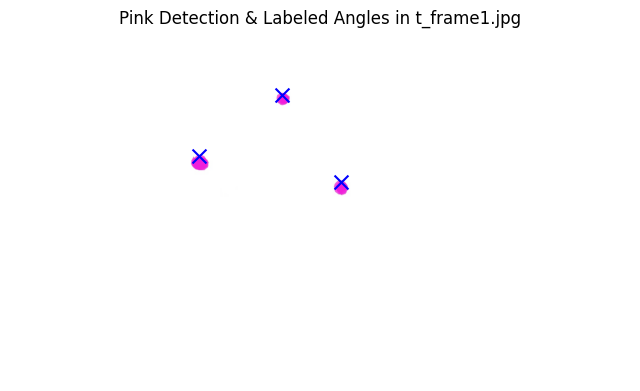

t_frame2.jpg - Labeled Angles: {'upper': 0.6994281070710494, 'lower_left': 1.6744372305555304, 'lower_right': 0.7677273159632123} (Runtime: 0.034666 s)


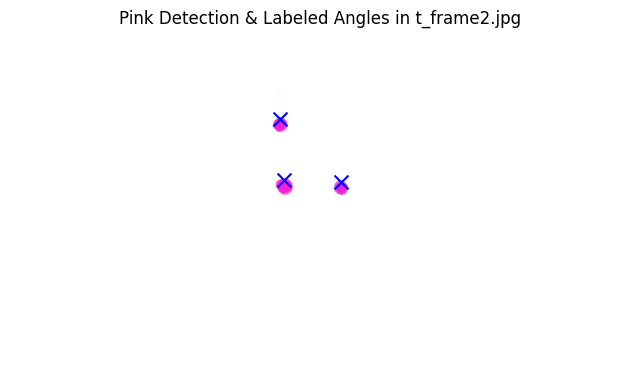

t_frame3.jpg - Labeled Angles: {'upper': 1.8252509761739244, 'lower_left': 0.40740303853116777, 'lower_right': 0.9089386388847003} (Runtime: 0.036529 s)


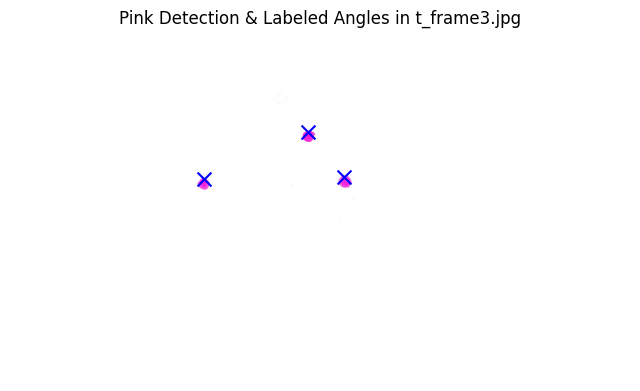

t_frame4.jpg - Labeled Angles: {'upper': 0.31634055306219455, 'lower_left': 0.33326953112007773, 'lower_right': 2.4919825694075195} (Runtime: 0.027213 s)


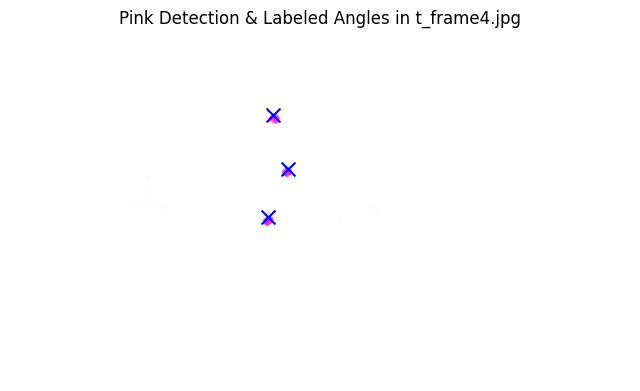

Processing s_set images:
s_frame1.jpg - Labeled Angles: {'upper': 1.4951483702459827, 'lower_left': 1.0559904207797979, 'lower_right': 0.5904538625640137} (Runtime: 0.032130 s)


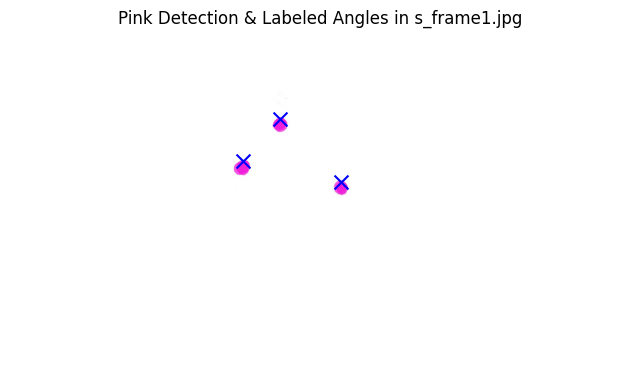

s_frame2.jpg - Labeled Angles: {'upper': 0.6240130849796516, 'lower_left': 1.852412588175338, 'lower_right': 0.6651669804348042} (Runtime: 0.061566 s)


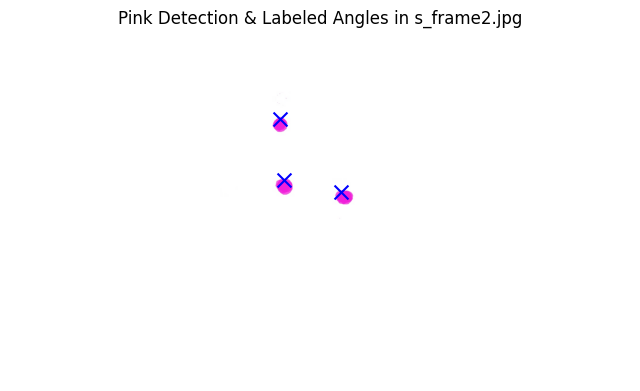

s_frame3.jpg - Labeled Angles: {'upper': 1.4705213173624139, 'lower_left': 0.5848475783232764, 'lower_right': 1.086223757904102} (Runtime: 0.055510 s)


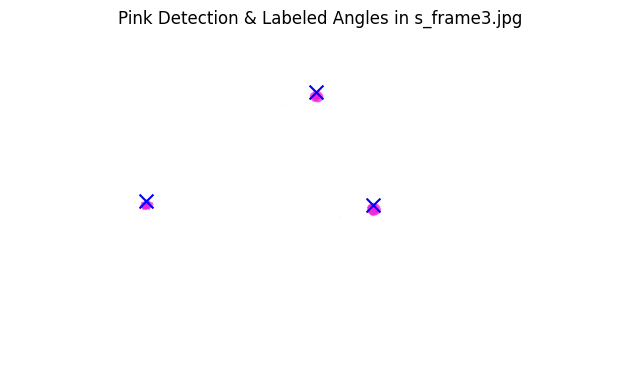

s_frame4.jpg - Labeled Angles: {'upper': 0.2643395472293344, 'lower_left': 0.3877634256767628, 'lower_right': 2.489489680683696} (Runtime: 0.047055 s)


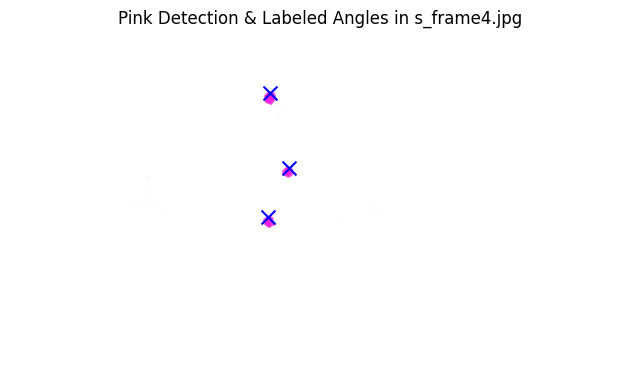


Angle Sequences:
t_set lower_left: [0.8182605926114057, 1.6744372305555304, 0.40740303853116777, 0.33326953112007773]
s_set lower_left: [1.0559904207797979, 1.852412588175338, 0.5848475783232764, 0.3877634256767628]
t_set lower_right: [0.8016909769610785, 0.7677273159632123, 0.9089386388847003, 2.4919825694075195]
s_set lower_right: [0.5904538625640137, 0.6651669804348042, 1.086223757904102, 2.489489680683696]
t_set upper: [1.521641084017309, 0.6994281070710494, 1.8252509761739244, 0.31634055306219455]
s_set upper: [1.4951483702459827, 0.6240130849796516, 1.4705213173624139, 0.2643395472293344]

DTW Distances:
Lower Left DTW: 0.647644
Lower Right DTW: 0.493575
Upper DTW: 0.508638
Total DTW Score (sum of all three): 1.649857

Total pipeline runtime: 2.503904 seconds


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

def cordic_atan(y, x, iterations=20):
    """
    Compute the arctan of y/x using the CORDIC algorithm.
    Returns the angle in radians.
    """
    angle = 0.0
    arctan_table = [math.atan(2**(-i)) for i in range(iterations)]

    # If x is negative, flip the vector and add pi.
    if x < 0:
        x, y = -x, -y
        angle = math.pi

    for i in range(iterations):
        d = 1 if y > 0 else -1
        x_new = x + d * y * (2 ** -i)
        y_new = y - d * x * (2 ** -i)
        angle += d * arctan_table[i]
        x, y = x_new, y_new
    return angle

def compute_triangle_angles(pts, iterations=20):
    """
    Given three points (shape (3,2)), compute the internal angles
    of the triangle using the CORDIC-based arctan.
    Returns a list of three angles (in radians) in the same order as pts.
    """
    angles = []
    for i in range(3):
        A = pts[i]
        B = pts[(i + 1) % 3]
        C = pts[(i + 2) % 3]
        # Vectors from A to B and from A to C
        v1 = (B[0] - A[0], B[1] - A[1])
        v2 = (C[0] - A[0], C[1] - A[1])
        angle1 = cordic_atan(v1[1], v1[0], iterations)
        angle2 = cordic_atan(v2[1], v2[0], iterations)
        angle_diff = abs(angle1 - angle2)
        if angle_diff > math.pi:
            angle_diff = 2 * math.pi - angle_diff
        angles.append(angle_diff)
    return angles

def label_triangle_angles_simplified(cluster_centers, triangle_angles):
    """
    Label the triangle vertices as:
      - 'upper': the vertex with the smallest y coordinate (upper in image coordinates).
      - 'lower_left': among the remaining vertices, the one with the smaller x coordinate.
      - 'lower_right': among the remaining vertices, the one with the larger x coordinate.
    Returns a dictionary mapping each label to its corresponding angle.
    """
    # cluster_centers: numpy array of shape (3,2) with columns (x, y)
    upper_idx = np.argmin(cluster_centers[:, 1])  # smallest y => upper
    other_indices = [i for i in range(3) if i != upper_idx]

    # Compare x coordinates of the two remaining vertices
    if cluster_centers[other_indices[0], 0] < cluster_centers[other_indices[1], 0]:
        lower_left_idx = other_indices[0]
        lower_right_idx = other_indices[1]
    else:
        lower_left_idx = other_indices[1]
        lower_right_idx = other_indices[0]

    labeled_angles = {
        'upper': triangle_angles[upper_idx],
        'lower_left': triangle_angles[lower_left_idx],
        'lower_right': triangle_angles[lower_right_idx]
    }
    return labeled_angles

def non_max_suppress_coordinates(mask, window=75, min_patch=9):
    """
    Given a binary mask, iterate over pink pixels and, for each pixel
    not already suppressed, check if a full min_patch x min_patch window (centered at that pixel)
    exists and is entirely pink.
    If so, record its coordinate and then suppress all pixels in a ±window neighborhood.
    Returns a list of (x, y) coordinates.
    """
    coords = np.argwhere(mask > 0)
    # Sort coordinates by row then column.
    coords = sorted(coords, key=lambda x: (x[0], x[1]))

    suppressed = np.zeros(mask.shape, dtype=bool)
    selected_coords = []

    half_patch = min_patch // 2  # For 9, half_patch = 4
    for (r, c) in coords:
        if suppressed[r, c]:
            continue

        # Check if a full min_patch x min_patch window centered at (r, c) exists
        r_min_check = r - half_patch
        r_max_check = r + half_patch + 1
        c_min_check = c - half_patch
        c_max_check = c + half_patch + 1

        # Ensure indices are within bounds and window is exactly min_patch x min_patch.
        if r_min_check < 0 or c_min_check < 0 or r_max_check > mask.shape[0] or c_max_check > mask.shape[1]:
            continue

        patch = mask[r_min_check:r_max_check, c_min_check:c_max_check]
        # Check if all pixels in the patch are pink (nonzero, assuming 255).
        if np.all(patch == 255):
            # Use this pixel as a representative coordinate.
            selected_coords.append((c, r))  # (x, y) format
            # Suppress the ±window neighborhood.
            r_min = max(r - window, 0)
            r_max = min(r + window + 1, mask.shape[0])
            c_min = max(c - window, 0)
            c_max = min(c + window + 1, mask.shape[1])
            suppressed[r_min:r_max, c_min:c_max] = True
    return selected_coords

def process_image(image_path):
    """
    Processes an image to:
      - Detect pink zones via HSV masking.
      - Use non-maximum suppression to directly pick representative pink pixel coordinates
        only if a full 9x9 patch of pink pixels exists.
      - Use these coordinates as the cluster centers.
      - Compute triangle internal angles using a CORDIC-based arctan.
      - Label the angles as 'upper', 'lower_left', and 'lower_right'.
      - Measure runtime.
    Returns the image, cluster_centers (as a numpy array), labeled_angles (a dict), and runtime.
    """
    start_time = time.time()

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found: " + image_path)

    # Convert image to HSV and threshold for pink.
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_pink = np.array([140, 50, 50])
    upper_pink = np.array([180, 255, 255])
    mask = cv2.inRange(image_hsv, lower_pink, upper_pink)

    # Use non-maximum suppression to get a sparse set of pink pixel coordinates,
    # but only consider a pixel if a full 9x9 patch exists.
    selected_coords = non_max_suppress_coordinates(mask, window=75, min_patch=9)

    if len(selected_coords) < 3:
        raise ValueError("Less than 3 valid pink detections found in " + image_path)

    # If more than 3 are found, choose the first three.
    if len(selected_coords) > 3:
        selected_coords = selected_coords[:3]

    cluster_centers = np.array(selected_coords)

    # Compute triangle angles using these coordinates.
    triangle_angles = compute_triangle_angles(cluster_centers, iterations=20)
    labeled_angles = label_triangle_angles_simplified(cluster_centers, triangle_angles)

    end_time = time.time()
    runtime = end_time - start_time
    return image, cluster_centers, labeled_angles, runtime

# Optimized DTW function provided
def DTWDistance(s, t):
    n = len(s)
    m = len(t)
    prev_row = np.full(m+1, np.inf)
    current_row = np.full(m+1, np.inf)
    prev_row[0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            current_row[j] = cost + min(prev_row[j], current_row[j-1], prev_row[j-1])
        prev_row[:] = current_row
        current_row[:] = np.inf
    return prev_row[m]

# Define image file sets
t_set = ['t_frame1.jpg', 't_frame2.jpg', 't_frame3.jpg', 't_frame4.jpg']
s_set = ['s_frame1.jpg', 's_frame2.jpg', 's_frame3.jpg', 's_frame4.jpg']

# Dictionaries to store labeled angles for DTW
labeled_angles_t = {}
labeled_angles_s = {}

# Start global timer for the entire pipeline
global_start_time = time.time()

print("Processing t_set images:")
for image_path in t_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_t[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Visualization turned on.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        plt.title(f"Pink Detection & Labeled Angles in {image_path}")
        plt.axis('off')
        plt.show()
    except ValueError as e:
        print(e)

print("Processing s_set images:")
for image_path in s_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_s[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Visualization turned on.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        plt.title(f"Pink Detection & Labeled Angles in {image_path}")
        plt.axis('off')
        plt.show()
    except ValueError as e:
        print(e)

# Build angle sequences for each label across images in t_set and s_set.
def build_angle_sequence(labeled_angles_dict, label, image_list):
    sequence = []
    for img in image_list:
        angles = labeled_angles_dict.get(img)
        if angles is not None:
            sequence.append(angles[label])
    return sequence

# For each label: lower_left, lower_right, and upper.
t_lower_left_seq = build_angle_sequence(labeled_angles_t, 'lower_left', t_set)
t_lower_right_seq = build_angle_sequence(labeled_angles_t, 'lower_right', t_set)
t_upper_seq = build_angle_sequence(labeled_angles_t, 'upper', t_set)

s_lower_left_seq = build_angle_sequence(labeled_angles_s, 'lower_left', s_set)
s_lower_right_seq = build_angle_sequence(labeled_angles_s, 'lower_right', s_set)
s_upper_seq = build_angle_sequence(labeled_angles_s, 'upper', s_set)

print("\nAngle Sequences:")
print("t_set lower_left:", t_lower_left_seq)
print("s_set lower_left:", s_lower_left_seq)
print("t_set lower_right:", t_lower_right_seq)
print("s_set lower_right:", s_lower_right_seq)
print("t_set upper:", t_upper_seq)
print("s_set upper:", s_upper_seq)

# Compute DTW distances for each angle sequence
dtw_lower_left = DTWDistance(t_lower_left_seq, s_lower_left_seq)
dtw_lower_right = DTWDistance(t_lower_right_seq, s_lower_right_seq)
dtw_upper = DTWDistance(t_upper_seq, s_upper_seq)

total_dtw = dtw_lower_left + dtw_lower_right + dtw_upper

print("\nDTW Distances:")
print(f"Lower Left DTW: {dtw_lower_left:.6f}")
print(f"Lower Right DTW: {dtw_lower_right:.6f}")
print(f"Upper DTW: {dtw_upper:.6f}")
print(f"Total DTW Score (sum of all three): {total_dtw:.6f}")

# End global timer and print total runtime
global_end_time = time.time()
print(f"\nTotal pipeline runtime: {global_end_time - global_start_time:.6f} seconds")


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

def cordic_atan(y, x, iterations=20):
    """
    Compute the arctan of y/x using the CORDIC algorithm.
    Returns the angle in radians.
    """
    angle = 0.0
    arctan_table = [math.atan(2**(-i)) for i in range(iterations)]

    # If x is negative, flip the vector and add pi.
    if x < 0:
        x, y = -x, -y
        angle = math.pi

    for i in range(iterations):
        d = 1 if y > 0 else -1
        x_new = x + d * y * (2 ** -i)
        y_new = y - d * x * (2 ** -i)
        angle += d * arctan_table[i]
        x, y = x_new, y_new
    return angle

def compute_triangle_angles(pts, iterations=20):
    """
    Given three points (shape (3,2)), compute the internal angles
    of the triangle using the CORDIC-based arctan.
    Returns a list of three angles (in radians) in the same order as pts.
    """
    angles = []
    for i in range(3):
        A = pts[i]
        B = pts[(i + 1) % 3]
        C = pts[(i + 2) % 3]
        # Vectors from A to B and from A to C
        v1 = (B[0] - A[0], B[1] - A[1])
        v2 = (C[0] - A[0], C[1] - A[1])
        angle1 = cordic_atan(v1[1], v1[0], iterations)
        angle2 = cordic_atan(v2[1], v2[0], iterations)
        angle_diff = abs(angle1 - angle2)
        if angle_diff > math.pi:
            angle_diff = 2 * math.pi - angle_diff
        angles.append(angle_diff)
    return angles

def label_triangle_angles_simplified(cluster_centers, triangle_angles):
    """
    Label the triangle vertices as:
      - 'upper': the vertex with the smallest y coordinate (upper in image coordinates).
      - 'lower_left': among the remaining vertices, the one with the smaller x coordinate.
      - 'lower_right': among the remaining vertices, the one with the larger x coordinate.
    Returns a dictionary mapping each label to its corresponding angle.
    """
    # cluster_centers: numpy array of shape (3,2) with columns (x, y)
    upper_idx = np.argmin(cluster_centers[:, 1])  # smallest y => upper
    other_indices = [i for i in range(3) if i != upper_idx]

    # Compare x coordinates of the two remaining vertices
    if cluster_centers[other_indices[0], 0] < cluster_centers[other_indices[1], 0]:
        lower_left_idx = other_indices[0]
        lower_right_idx = other_indices[1]
    else:
        lower_left_idx = other_indices[1]
        lower_right_idx = other_indices[0]

    labeled_angles = {
        'upper': triangle_angles[upper_idx],
        'lower_left': triangle_angles[lower_left_idx],
        'lower_right': triangle_angles[lower_right_idx]
    }
    return labeled_angles

def non_max_suppress_coordinates(mask, window=75, min_patch=9):
    """
    Given a binary mask, iterate over pink pixels and, for each pixel
    not already suppressed, check if a full min_patch x min_patch window (centered at that pixel)
    exists and is entirely pink.
    If so, record its coordinate and then suppress all pixels in a ±window neighborhood.
    Returns a list of (x, y) coordinates.
    """
    coords = np.argwhere(mask > 0)
    # Sort coordinates by row then column.
    coords = sorted(coords, key=lambda x: (x[0], x[1]))

    suppressed = np.zeros(mask.shape, dtype=bool)
    selected_coords = []

    half_patch = min_patch // 2  # For 9, half_patch = 4
    for (r, c) in coords:
        if suppressed[r, c]:
            continue

        # Check if a full min_patch x min_patch window centered at (r, c) exists
        r_min_check = r - half_patch
        r_max_check = r + half_patch + 1
        c_min_check = c - half_patch
        c_max_check = c + half_patch + 1

        # Ensure indices are within bounds and window is exactly min_patch x min_patch.
        if r_min_check < 0 or c_min_check < 0 or r_max_check > mask.shape[0] or c_max_check > mask.shape[1]:
            continue

        patch = mask[r_min_check:r_max_check, c_min_check:c_max_check]
        # Check if all pixels in the patch are pink (nonzero, assuming 255).
        if np.all(patch == 255):
            # Use this pixel as a representative coordinate.
            selected_coords.append((c, r))  # (x, y) format
            # Suppress the ±window neighborhood.
            r_min = max(r - window, 0)
            r_max = min(r + window + 1, mask.shape[0])
            c_min = max(c - window, 0)
            c_max = min(c + window + 1, mask.shape[1])
            suppressed[r_min:r_max, c_min:c_max] = True
    return selected_coords

def process_image(image_path):
    """
    Processes an image to:
      - Detect pink zones via HSV masking.
      - Use non-maximum suppression to directly pick representative pink pixel coordinates
        only if a full 9x9 patch of pink pixels exists.
      - Use these coordinates as the cluster centers.
      - Compute triangle internal angles using a CORDIC-based arctan.
      - Label the angles as 'upper', 'lower_left', and 'lower_right'.
      - Measure runtime.
    Returns the image, cluster_centers (as a numpy array), labeled_angles (a dict), and runtime.
    """
    start_time = time.time()

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found: " + image_path)

    # Convert image to HSV and threshold for pink.
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_pink = np.array([140, 50, 50])
    upper_pink = np.array([180, 255, 255])
    mask = cv2.inRange(image_hsv, lower_pink, upper_pink)

    # Use non-maximum suppression to get a sparse set of pink pixel coordinates,
    # but only consider a pixel if a full 9x9 patch exists.
    selected_coords = non_max_suppress_coordinates(mask, window=75, min_patch=9)

    if len(selected_coords) < 3:
        raise ValueError("Less than 3 valid pink detections found in " + image_path)

    # If more than 3 are found, choose the first three.
    if len(selected_coords) > 3:
        selected_coords = selected_coords[:3]

    cluster_centers = np.array(selected_coords)

    # Compute triangle angles using these coordinates.
    triangle_angles = compute_triangle_angles(cluster_centers, iterations=20)
    labeled_angles = label_triangle_angles_simplified(cluster_centers, triangle_angles)

    end_time = time.time()
    runtime = end_time - start_time
    return image, cluster_centers, labeled_angles, runtime

# Optimized DTW function provided
def DTWDistance(s, t):
    n = len(s)
    m = len(t)
    prev_row = np.full(m+1, np.inf)
    current_row = np.full(m+1, np.inf)
    prev_row[0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            current_row[j] = cost + min(prev_row[j], current_row[j-1], prev_row[j-1])
        prev_row[:] = current_row
        current_row[:] = np.inf
    return prev_row[m]

# Define image file sets
t_set = ['t_frame1.jpg', 't_frame2.jpg', 't_frame3.jpg', 't_frame4.jpg']
s_set = ['s_frame1.jpg', 's_frame2.jpg', 's_frame3.jpg', 's_frame4.jpg']

# Dictionaries to store labeled angles for DTW
labeled_angles_t = {}
labeled_angles_s = {}

# Start global timer for the entire pipeline
global_start_time = time.time()

print("Processing t_set images:")
for image_path in t_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_t[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Visualization turned on.
        #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       # plt.figure(figsize=(8, 6))
        #plt.imshow(image_rgb)
        #plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        #plt.title(f"Pink Detection & Labeled Angles in {image_path}")
        #plt.axis('off')
        #plt.show()
    except ValueError as e:
        print(e)

print("Processing s_set images:")
for image_path in s_set:
    try:
        image, cluster_centers, labeled_angles, runtime = process_image(image_path)
        labeled_angles_s[image_path] = labeled_angles
        print(f"{image_path} - Labeled Angles: {labeled_angles} (Runtime: {runtime:.6f} s)")

        # Visualization turned off.
        #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #plt.figure(figsize=(8, 6))
        #plt.imshow(image_rgb)
        #plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x', s=100)
        #plt.title(f"Pink Detection & Labeled Angles in {image_path}")
        #plt.axis('off')
        #plt.show()
    except ValueError as e:
        print(e)

# Build angle sequences for each label across images in t_set and s_set.
def build_angle_sequence(labeled_angles_dict, label, image_list):
    sequence = []
    for img in image_list:
        angles = labeled_angles_dict.get(img)
        if angles is not None:
            sequence.append(angles[label])
    return sequence

# For each label: lower_left, lower_right, and upper.
t_lower_left_seq = build_angle_sequence(labeled_angles_t, 'lower_left', t_set)
t_lower_right_seq = build_angle_sequence(labeled_angles_t, 'lower_right', t_set)
t_upper_seq = build_angle_sequence(labeled_angles_t, 'upper', t_set)

s_lower_left_seq = build_angle_sequence(labeled_angles_s, 'lower_left', s_set)
s_lower_right_seq = build_angle_sequence(labeled_angles_s, 'lower_right', s_set)
s_upper_seq = build_angle_sequence(labeled_angles_s, 'upper', s_set)

print("\nAngle Sequences:")
print("t_set lower_left:", t_lower_left_seq)
print("s_set lower_left:", s_lower_left_seq)
print("t_set lower_right:", t_lower_right_seq)
print("s_set lower_right:", s_lower_right_seq)
print("t_set upper:", t_upper_seq)
print("s_set upper:", s_upper_seq)

# Compute DTW distances for each angle sequence
dtw_lower_left = DTWDistance(t_lower_left_seq, s_lower_left_seq)
dtw_lower_right = DTWDistance(t_lower_right_seq, s_lower_right_seq)
dtw_upper = DTWDistance(t_upper_seq, s_upper_seq)

total_dtw = dtw_lower_left + dtw_lower_right + dtw_upper

print("\nDTW Distances:")
print(f"Lower Left DTW: {dtw_lower_left:.6f}")
print(f"Lower Right DTW: {dtw_lower_right:.6f}")
print(f"Upper DTW: {dtw_upper:.6f}")
print(f"Total DTW Score (sum of all three): {total_dtw:.6f}")

# End global timer and print total runtime
global_end_time = time.time()
print(f"\nTotal pipeline runtime: {global_end_time - global_start_time:.6f} seconds")


Processing t_set images:
t_frame1.jpg - Labeled Angles: {'upper': 1.521641084017309, 'lower_left': 0.8182605926114057, 'lower_right': 0.8016909769610785} (Runtime: 0.029827 s)
t_frame2.jpg - Labeled Angles: {'upper': 0.6994281070710494, 'lower_left': 1.6744372305555304, 'lower_right': 0.7677273159632123} (Runtime: 0.039155 s)
t_frame3.jpg - Labeled Angles: {'upper': 1.8252509761739244, 'lower_left': 0.40740303853116777, 'lower_right': 0.9089386388847003} (Runtime: 0.026724 s)
t_frame4.jpg - Labeled Angles: {'upper': 0.31634055306219455, 'lower_left': 0.33326953112007773, 'lower_right': 2.4919825694075195} (Runtime: 0.025508 s)
Processing s_set images:
s_frame1.jpg - Labeled Angles: {'upper': 1.4951483702459827, 'lower_left': 1.0559904207797979, 'lower_right': 0.5904538625640137} (Runtime: 0.029821 s)
s_frame2.jpg - Labeled Angles: {'upper': 0.6240130849796516, 'lower_left': 1.852412588175338, 'lower_right': 0.6651669804348042} (Runtime: 0.031507 s)
s_frame3.jpg - Labeled Angles: {'uppe